## Prepare the datasets

<font size="2"> To install new library (since everything is running on kernel python3.10): 
/$ python3.10 -m pip install *pandas*
</font>

In [1]:
# import all files from necessary directory
from utils.labels_utils import get_all_files_mhd
all_files_mhd = get_all_files_mhd("/data/Riabova/train/train_depth_0_70/")
len(all_files_mhd)

110

In [95]:
from utils.type_reader import mha_read_header
import numpy as np
from utils.labels_utils import get_labels
from tqdm import tqdm

# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
labels = np.empty((1, 3))
i = 0
for f in all_files_mhd:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    info = mha_read_header(f)
    labels = np.concatenate((labels, get_labels(f, info)), axis = 0)
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*info['Dimensions'][3]), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, info['Dimensions'][3])), axis=0)
    i+=1
    
all_frames_filenames_array = all_frames_filenames_array[ 1:]
labels = labels[1:, :]
frame_nums = frame_nums[1:]

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...


In [4]:
X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
y = labels
print(X.shape)
print(X[0, :])
print(y[0, :])

(2356, 2)
['/data/Riabova/train/train_depth_0_70/10_0_-3_0_0_0_4_2_1689851213927661.mhd'
 '0.0']
[ 99.57817325 109.4948     125.6625    ]


[132.09358475 109.4948     125.6625    ]


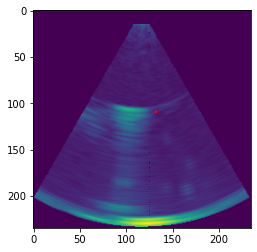

In [5]:
from matplotlib import pyplot as plt, patches
from utils.type_reader import get_image_array

#Check that frames are being displayed correctly
img_num = 10
input_image = get_image_array(X[img_num][0])
frame_num = int(float(X[img_num][1]))
label = labels[img_num]
print(label)
fig = plt.figure()
ax = fig.add_subplot()
plt.imshow(input_image[:, :, int(label[2]), frame_num].T)
ax.add_patch(patches.Circle((int(label[0]), int(label[1])), radius=1, color='red'))
plt.show()

In [5]:
VALID_PERCENT = 0.2
TEST_PERCENT = 0.2
BATCH_TRAIN = 10
BATCH_VALID = 10
BATCH_TEST = 10
RESIZE_TO = 228 # original size - 235

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_vt, y_train, y_vt = train_test_split(X[:, :], y[:, :], test_size=VALID_PERCENT+TEST_PERCENT, random_state=42, shuffle = True)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt[:, :], y_vt[:, :], test_size=TEST_PERCENT/(VALID_PERCENT+TEST_PERCENT), random_state=42,shuffle=True)
print(f"Total training images: {X_train.shape[0]}")
print(f"Total validation images: {X_valid.shape[0]}")
print(f"Total test images: {X_test.shape[0]}")

Total training images: 1413
Total validation images: 471
Total test images: 472


In [7]:
X_train.shape

(1413, 2)

In [8]:
from utils.ImageDataset import ImageDataset, my_collate
import torch

train_dataset = ImageDataset(X_train, y_train, resizeTo=RESIZE_TO)
valid_dataset = ImageDataset(X_valid, y_valid, resizeTo=RESIZE_TO)
test_dataset = ImageDataset(X_test, y_test, resizeTo=RESIZE_TO)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=True, collate_fn=my_collate)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=True, collate_fn=my_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_TEST,shuffle=True, collate_fn=my_collate)

In [9]:
# this cell is intended just to check dimensions:
for sample_batched in train_dataloader:
    print(sample_batched['image'].shape)
    break

torch.Size([10, 1, 228, 228, 228])


## convnet

##### Maybe the model still has potential, but the loss function needs to be changed from CrossEntropyLoss to converting the class back to the 3d coordinate and minimizing the distance

In [15]:
SPLIT_PERCENT = 0.2
IMG_SIZE = 135
EPOCHS = 5
INIT_LR = 0.001
WEIGHT_DECAY = 1e-8
MOMENTUM = 0.999

# define threshold to filter weak predictions
THRESHOLD = 0.5

In [16]:
# device will be 'cuda' if a GPU is available
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
device

'cpu'

In [17]:
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from models.convnet import CNN_classification_model

model = CNN_classification_model(side_size = RESIZE_TO)
optimizer = optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
criterion = nn.CrossEntropyLoss()

In [18]:
model

CNN_classification_model(
  (model): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (7): ReLU()
    (8): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=27648, out_features=128, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.15, inplace=False)
    (14): Linear(in_features=128, out_features=262144, bias=True)
    (15): Softmax(dim=None)
  )
)

In [19]:
import numpy as np
import torch


class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, sample_batched in batch_iter:
            input, target = sample_batched['image'].to(self.device), sample_batched['label_1D'].to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            out_np = out.detach().numpy()
            print("Result of iteration:")
            print(np.argmax(out_np, axis = 1))
            print("Ground truth:")
            print(target.detach().numpy())
            # out = out[:, np.newaxis, :, :, :]
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, sample_batched in batch_iter:
            input, target = sample_batched['image'].to(self.device), sample_batched['label_1D'].to(self.device)   # send to device (GPU or CPU)

            
            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

In [20]:
# trainer

trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_dataloader,
                  validation_DataLoader=valid_dataloader,
                  lr_scheduler=None,
                  epochs=2,
                  epoch=0,
                  notebook=True)

In [ ]:
# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

## u-net
##### mask was created after image is resized to make the mask area a bit bigger

In [9]:
# init number of epochs to train for, and the
# batch size of train and validation sets
EPOCHS = 10
UNET_DEPTH = 4 # size of the image should divide by this number
UNET_START_FILTERS = 3

#For LR scheduler
INIT_LR = 0.001
WEIGHT_DECAY = 1e-8
MOMENTUM = 0.999

# define threshold to filter weak predictions
THRESHOLD = 0.5

In [10]:
import torch
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda')

In [51]:
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from models.unet import UNet
from utils.losses import IoULossModified
from utils.save_model_utils import SaveBestModel

model = UNet(out_channels = 1, n_blocks=UNET_DEPTH, start_filts = UNET_START_FILTERS)
optimizer = optim.Adam(model.parameters()) #optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
criterion = IoULossModified()
save_best_model = SaveBestModel()

In [52]:
model

UNet(
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DownConv(
      (conv1): Conv3d(3, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(6, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(6

In [54]:
import numpy as np
import torch
from utils.display_utils import compare_input_target
from utils.save_model_utils import save_model, save_plots, save_sample_mask
from utils.accuracies import get_central_pixel_distance, get_pixel_accuracy_percent

class TrainerUNET:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.center_pixel_distances = []
        self.pixelwise_accuracy = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:

            """Epoch counter"""
            self.epoch += 1  # epoch counter
            
            print(f"[INFO]: Epoch {self.epoch} of {self.epochs}")

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()
                
            print(f"Training loss: {self.training_loss[-1]:.3f}")
            print(f"Validation loss: {self.validation_loss[-1]:.3f}")
            # save the best model till now if we have the least loss in the current epoch
            save_best_model(self.validation_loss[-1], self.epoch, self.model, self.optimizer, self.criterion)
            print('-'*50)
            
            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
                    
        # save the trained model weights for a final time
        save_model(self.epochs, self.model, self.optimizer, self.criterion)
        # save the loss and accuracy plots
        save_plots(self.training_loss[-1], self.validation_loss[-1], self.center_pixel_distances[-1], self.pixelwise_accuracy[-1])
        print('TRAINING COMPLETE')
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        pixelwise_accuracy_within_batch = []
        center_pixel_distance_within_batch = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, sample_batched in batch_iter:
            input, target, labels = sample_batched['image'].to(self.device), sample_batched['mask'].to(self.device), sample_batched['label'].to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            # out = out[:, np.newaxis, :, :, :]
            # compare_input_target(out[0], sample_batched['mask'][0])
            if i%30 == 0:
                save_sample_mask(self.epoch, i, out[0], sample_batched['mask'][0])
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            pixelwise_accuracy_within_batch.append(get_pixel_accuracy_percent(out, target))
            center_pixel_distance_within_batch.append(get_central_pixel_distance(out, labels))
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.pixelwise_accuracy.append(np.mean(pixelwise_accuracy_within_batch))
        self.center_pixel_distances.append(np.mean(center_pixel_distance_within_batch))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, sample_batched in batch_iter:
            input, target = sample_batched['image'].to(self.device), sample_batched['mask'].to(self.device)   # send to device (GPU or CPU)

            
            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

In [55]:
# trainer

trainer = TrainerUNET(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_dataloader,
                  validation_DataLoader=valid_dataloader,
                  lr_scheduler=None,
                  epochs=EPOCHS,
                  epoch=0,
                  notebook=True)

In [ ]:
# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

## Check the best model
##### load the best saved model, make a prediction of the test batch and research process of loss calculation

In [11]:
import torch 

# Model class must be defined somewhere
state = torch.load('outputs_side_128_partial/best_model.pth')

In [12]:
from models.unet import UNet
from torch import optim


model = UNet(out_channels = 1, n_blocks=UNET_DEPTH, start_filts = UNET_START_FILTERS)
optimizer = optim.Adam(model.parameters()) #optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)

model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])

In [ ]:
sample_batched = next(iter(test_dataloader))
model = model
input, target = sample_batched['image'], sample_batched['mask']  # send to device (GPU or CPU)
out = model(input)  # one forward pass

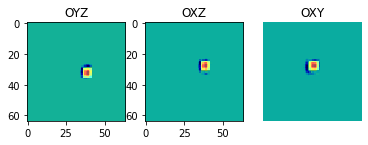

In [23]:
from utils.save_model_utils import save_sample_mask
save_sample_mask(100, 0, out[0], target[0], save = False)

In [24]:
from utils.accuracies import get_central_pixel_distance, get_pixel_accuracy_percent

get_pixel_accuracy_percent(out, target)

99.97013211250305

In [26]:
get_central_pixel_distance(out, sample_batched['label'].to(device))

6.184872221156726